# Fruit image classifiers

- Import essential libraries

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import os

2024-02-19 07:06:04.130718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 07:06:04.130823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 07:06:04.251135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- Define train and test path 

In [4]:
train_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training"
test_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test"

# Data preprocessing
- Let's start by analyzing a simple image in the training set

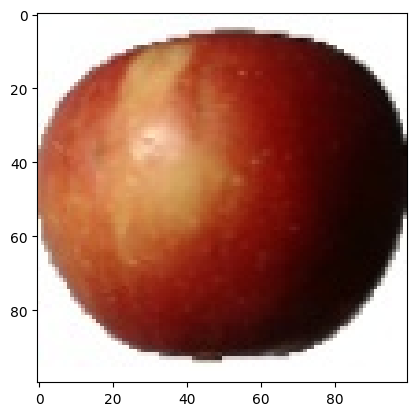

In [5]:
img = load_img(train_path + "/Apple Braeburn/0_100.jpg")
plt.imshow(img)

In [6]:
image_array = np.array(img)
print(image_array.shape)

(100, 100, 3)


By converting the image in matrix form, we get the dimension 100x100x3.  
Each image of the dataset has that size as specified in the dataset description.  
The third coordinate is used to specify the channel which means the color that in this case is RGB.

The following code is used for **data augmentation** by retrieving also the labels of each images.  
The data augmentation is done especially for trainingSet. In particular the operation performed are:
- Rescaling -> this maps the images into matrices with values in [0,1]
- Shear
- Horizontal flip
- Vertical flip
- Zoom  

While for testSet we just need to use the rescale parameter.

Then we give the **train_path and test_path** to **generate couple (x_train, labels)** where **labels are inferred automatically from the directory names**.

In [7]:
# Adding data augmentation for trainingSet
print("Define data augmentation for training and validation set....")
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   zoom_range = 0.3,
                                   validation_split=0.2)


# Generate the batches by giving the trainingSet calculating automatically the labels
print("Generate batches for training set....")
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(100,100),
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    class_mode="categorical",                                                    
                                                    shuffle=True,
                                                    subset='training')
print("Generate batches for validation set....")
valid_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(100,100),
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    class_mode="categorical",                                                    
                                                    shuffle=True,
                                                    subset='validation')

# Adding scaling for testSet
print("Define data augmentation for test set....")
test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate the batches by giving the testSet
print("Generate batches for test set....")
test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size=(100,100),
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    shuffle=False)



Define data augmentation for training and validation set....
Generate batches for training set....
Found 54190 images belonging to 131 classes.
Generate batches for validation set....
Found 13502 images belonging to 131 classes.
Define data augmentation for test set....
Generate batches for test set....
Found 22688 images belonging to 131 classes.


In total we have 90380 images.  
We know it's a multiclass image classification and we also know we have 131 classes.

## Build the model
In this section we now build the CNN model.  
First thing first we need to add Keras library and its classes. 

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [9]:
from keras.optimizers import Adam
# Initialize the model
model = Sequential()

# First convolutional layer
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)))
# Pooling layer to diminish dimension
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output in onedimensional for fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(64, activation='relu'))
# Add output layer with 131 parameters that corresponds to the number of classes
model.add(Dense(131, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [10]:
# Add an early stopping
stop_early = EarlyStopping(monitor='val_accuracy', patience = 5)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,           
        steps_per_epoch = train_generator.samples//64,        
        validation_data=valid_generator,
        validation_steps = valid_generator.samples//64,
        epochs = 30, 
        batch_size = 64, 
        shuffle = True, 
        callbacks = [stop_early])

Epoch 1/30


I0000 00:00:1708326408.691230     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


846/846 [==============================] - 645s 758ms/step - loss: 1.4373 - accuracy: 0.5983 - val_loss: 0.6439 - val_accuracy: 0.8090
Epoch 2/30
846/846 [==============================] - 277s 328ms/step - loss: 0.3338 - accuracy: 0.8894 - val_loss: 0.4824 - val_accuracy: 0.8647
Epoch 3/30
846/846 [==============================] - 262s 310ms/step - loss: 0.2078 - accuracy: 0.9322 - val_loss: 0.4325 - val_accuracy: 0.8811
Epoch 4/30
846/846 [==============================] - 262s 309ms/step - loss: 0.1272 - accuracy: 0.9585 - val_loss: 0.4042 - val_accuracy: 0.9003
Epoch 5/30
846/846 [==============================] - 268s 317ms/step - loss: 0.1208 - accuracy: 0.9609 - val_loss: 0.3084 - val_accuracy: 0.9170
Epoch 6/30
846/846 [==============================] - 269s 318ms/step - loss: 0.0902 - accuracy: 0.9707 - val_loss: 0.2899 - val_accuracy: 0.9203
Epoch 7/30
846/846 [==============================] - 257s 304ms/step - loss: 0.0904 - accuracy: 0.9708 - val_loss: 0.2713 - val_accura

- Saving the trained model

In [11]:
model.save('/kaggle/working/Fruits360NewFinal.keras')

In [12]:
# Test model on test_generator
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

355/355 [==============================] - 168s 473ms/step - loss: 0.3008 - accuracy: 0.9402
Test loss: 0.3007872402667999
Test accuracy: 0.9401886463165283


## Evaluation:
In the following section we are going to calculate the classical accuracy measurements.

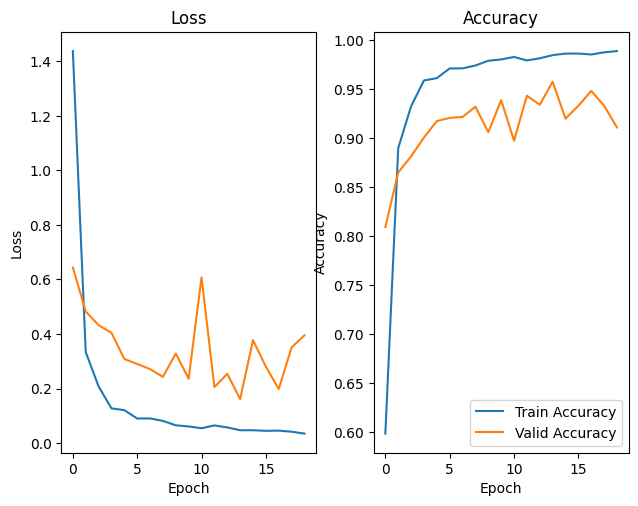

In [33]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Train Loss')
  ax[0].plot(valid_loss, label='Valid Loss')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Train Accuracy')
  ax[1].plot(valid_acc, label='Valid Accuracy')
  plt.legend()
  plt.show()

plot_performance(history)


### Precision, Recall, and F1 Score:

In [19]:
from sklearn.metrics import classification_report
import pandas as pd
# Get predictions
y_pred = model.predict(test_generator, steps = test_generator.samples/64)

354/354 [==============================] - 23s 66ms/step


In [41]:
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)

# export in csv format
report = classification_report(y_true, y_pred_classes, output_dicet=True)
df = pd.DataFrame(report)

# Generate LaTeX output
csv_output = df.to_csv()
df.to_csv('classification_report.csv')


              precision    recall  f1-score   support

           0       0.75      0.86      0.80       164
           1       1.00      0.57      0.73       148
           2       0.92      1.00      0.96       160
           3       1.00      0.95      0.97       164
           4       0.89      1.00      0.94       161
           5       1.00      0.90      0.95       164
           6       0.54      1.00      0.71       152
           7       0.81      1.00      0.89       164
           8       0.88      1.00      0.93       164
           9       0.95      1.00      0.97       144
          10       1.00      0.96      0.98       166
          11       1.00      0.75      0.86       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       1.00      0.99      1.00       166
          16       1.00      0.93      0.96       166
          17       1.00    

TypeError: classification_report() got an unexpected keyword argument 'output_dicet'

### Confusion matrix:

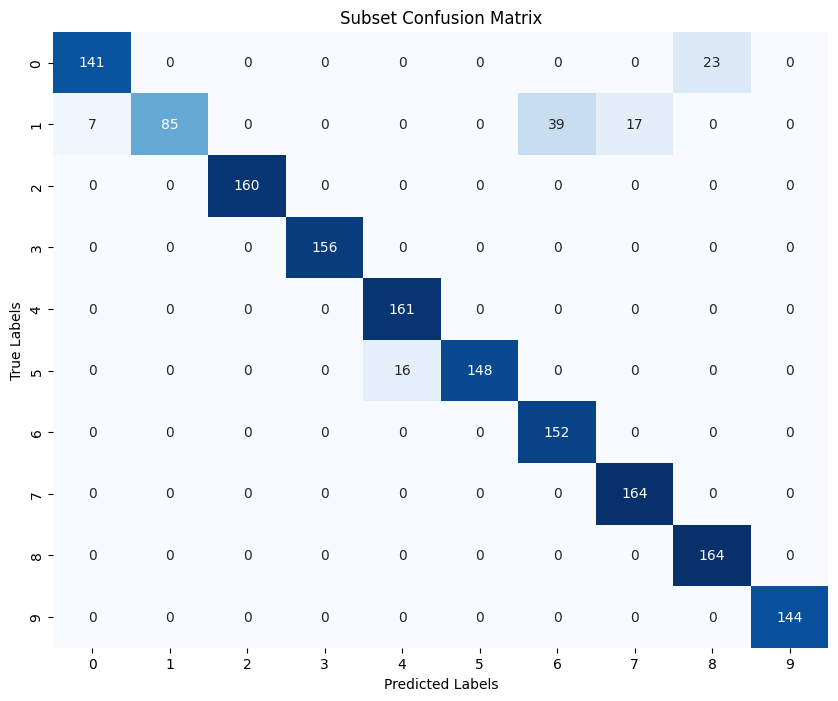

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Select a subset of classes (e.g., first 10 classes)
subset_classes =  [i for i in range(10)]
subset_matrix = conf_matrix[:10, :10]

# Plot subset of confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Subset Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.yticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.show()

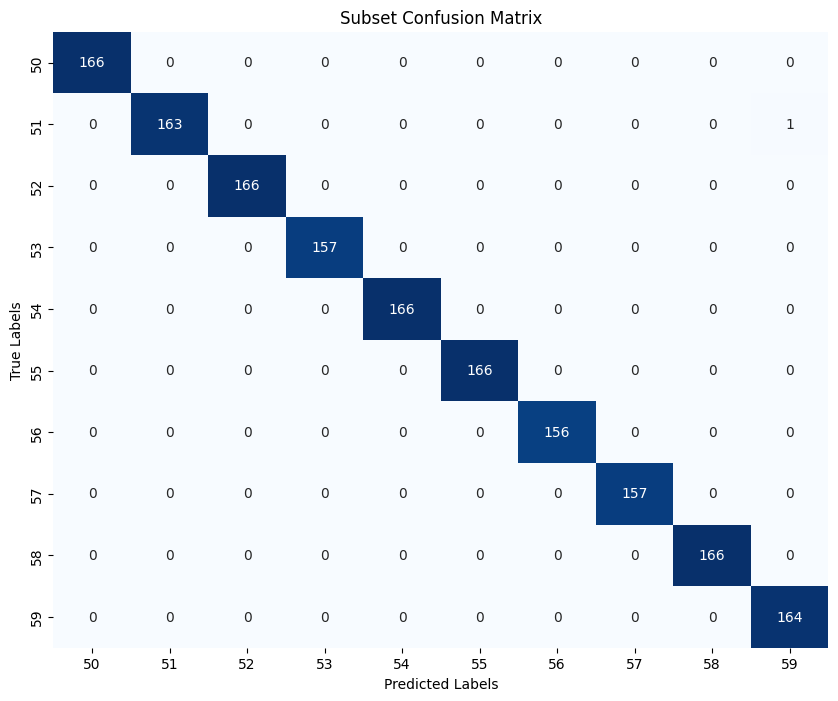

In [44]:
subset_classes =  [i for i in range(50, 60)]
subset_matrix = conf_matrix[50:60, 50:60]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Subset Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.yticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.show()

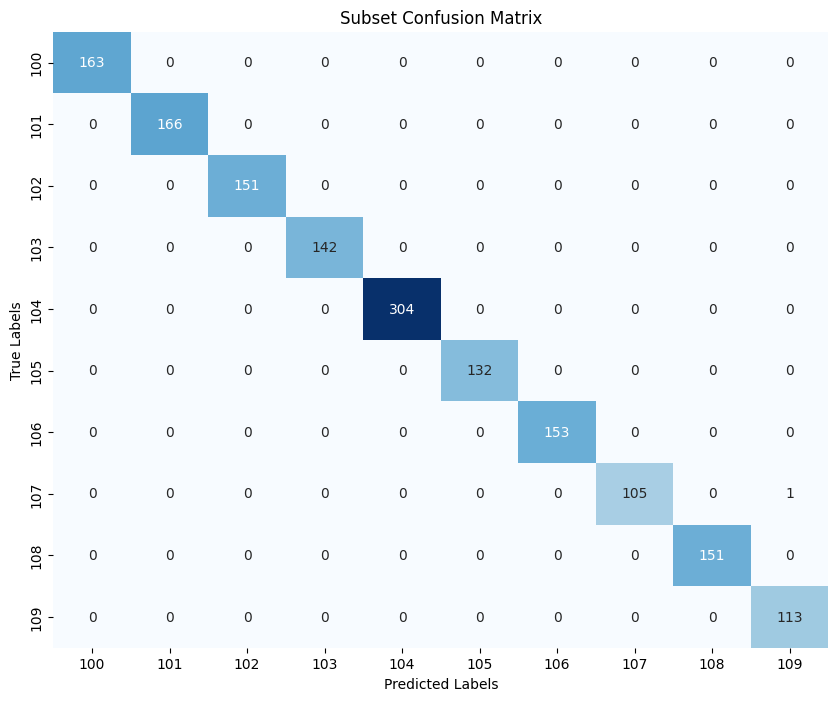

In [45]:
subset_classes =  [i for i in range(100, 110)]
subset_matrix = conf_matrix[100:110, 100:110]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Subset Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.yticks(np.arange(len(subset_classes)) + 0.5, subset_classes)
plt.show()